# Import packages

In [1]:
import glob
import nltk
from config import Config
import gensim
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

# Load text

In [2]:
def input_data(text_file_directory=Config.TEXT_DATA_PATH):
    """
    Reads the text documents contained in text_file_directory
    :param text_file_directory: Path to directory (String)
    :return: List where one element in a word in the text. The text order is kept. (List of String)
    """
    list_of_words = []
    for file_path in glob.glob(text_file_directory):
        with open(file_path, 'r', errors="ignore") as f:
            content = ''.join(f.readlines())
            content.replace('  ', ' ')
            list_of_current_words = content.split(' ')
            list_of_current_words = [x.lower() for x in list_of_current_words if x != '']
            list_of_words.append(list_of_current_words)
    return list_of_words

In [3]:
data = input_data()

In [4]:
print(f"We have {len(data)} document with an average of {np.mean([len(elt) for elt in data])} words.")

We have 100 document with an average of 7187.03 words.


`data` will be a list of list. Each element will contain one file.

In [5]:
print("\n".join([str(elt[:15]) for elt in data[:2]]))

['analysis', 'china', 'dominates', 'airwaves', 'with', 'vat', 'and', 'lower', 'prices', 'the', 'market', 'has', 'been', 'awash', 'with']
['analysis', 'subdued', 'are', 'the', 'phosphate', 'markets,', 'east', 'and', 'west', 'with', 'the', 'exception', 'of', 'pakistan', 'where']


And each file is pre-processed to tokenize words.

In [6]:
print(gensim.utils.simple_preprocess("Ort."))

['ort']


# Build model

Parameters:
- `size`: (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).
- `window`: (default 5) The maximum distance between a target word and words around the target word.
- `min_count`: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
- `workers`: (default 3) The number of threads to use while training.
- `sg`: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).

In [7]:
# build vocabulary and train model
# model = gensim.models.Word2Vec(data, size=32, window=10, min_count=2,workers=4,sg=1)
# model.save("word2vec.model")
model = gensim.models.Word2Vec.load("word2vec.model")

Print the vocabulary used

In [8]:
print("\n".join([str((str(k), str(v), str([f"{elt:.2}" for elt in model[k][:4]])+'...')) for k,v in list(model.wv.vocab.items())[:10]]))

('analysis', 'Vocab(count:197, index:476, sample_int:4294967296)', "['-0.15', '0.6', '-0.21', '1.0']...")
('china', 'Vocab(count:1304, index:82, sample_int:4294967296)', "['0.81', '0.19', '-0.51', '0.46']...")
('with', 'Vocab(count:5077, index:14, sample_int:2193243371)', "['0.21', '0.69', '0.17', '0.43']...")
('vat', 'Vocab(count:41, index:1751, sample_int:4294967296)', "['0.16', '0.65', '-0.29', '0.025']...")
('and', 'Vocab(count:12516, index:3, sample_int:1259311112)', "['0.096', '0.32', '0.22', '0.3']...")
('lower', 'Vocab(count:912, index:117, sample_int:4294967296)', "['0.41', '0.78', '-0.2', '0.28']...")
('prices', 'Vocab(count:4397, index:16, sample_int:2404392624)', "['0.28', '0.77', '0.097', '0.14']...")
('the', 'Vocab(count:25918, index:1, sample_int:823958341)', "['-0.46', '0.68', '0.1', '0.19']...")
('market', 'Vocab(count:1998, index:47, sample_int:4059480107)', "['0.26', '0.51', '-0.33', '0.4']...")
('has', 'Vocab(count:2474, index:30, sample_int:3510463341)', "['-0.076'

# Working with the whole new word embeddings

We can find the closest words to a particular word appearing in the dataset.

In [17]:
model.wv.most_similar(positive="phosphate", topn=5)

[('rock', 0.8904851078987122),
 ('rock,', 0.8123131990432739),
 ('somiphos', 0.8061442375183105),
 ('peruvian', 0.8054100275039673),
 ("peru's", 0.8002829551696777)]

In [20]:
# model = gensim.models.Word2Vec.load("word2vec.model")
X = model[model.wv.vocab]
print(X.shape)

(14186, 32)


Filter to keep only the 100 most used words (to display them)

In [12]:
count = []
for word, vocab_obj in model.wv.vocab.items():
    count.append((word, vocab_obj.count))
count.sort(key=lambda tup: tup[1], reverse=True)
most_used_words = [w for w, c in count[:100]]
sub_X = model[most_used_words]
print(sub_X.shape)

(100, 32)


Perform a PCA to display the distribution of the 100 most used words.

In [13]:
pca = PCA(n_components=2)
result = pca.fit_transform(sub_X)

Fit a KMeans algorithm with 4 clusters to classify points

In [23]:
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100)  
kmeans_model.fit(sub_X)
labels=kmeans_model.labels_.tolist()

Plot results

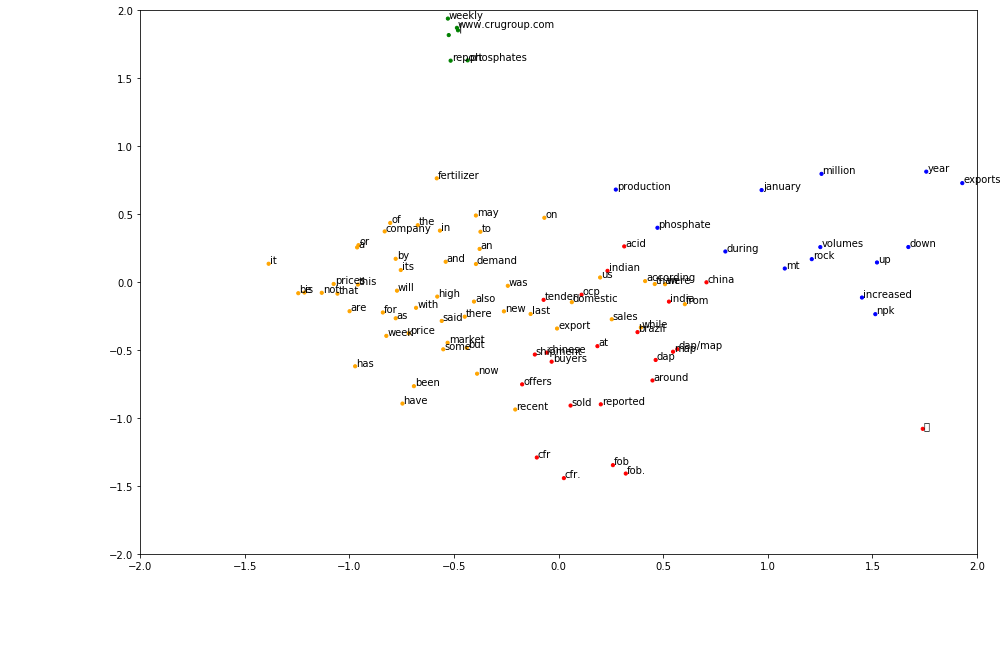

In [16]:
label1 = ["blue", "orange", "red", "green"]
color = [label1[i] for i in labels]
plt.scatter(result[:, 0], result[:, 1], s=10,color=color)
# words = list(model.wv.vocab)
for i, word in enumerate(most_used_words):
    plt.annotate(word, xy=(result[i, 0]+0.005, result[i, 1]+0.005))
plt.xlim((-2,2))
plt.ylim((-2,2));

# KMeans

Now on the whole dataset, we want to classify points into groups using the word embedding matrix. Which $k$ should be choose?
Let's plot the SSE (sum of squared errors) to choose the optimum number of clusters.

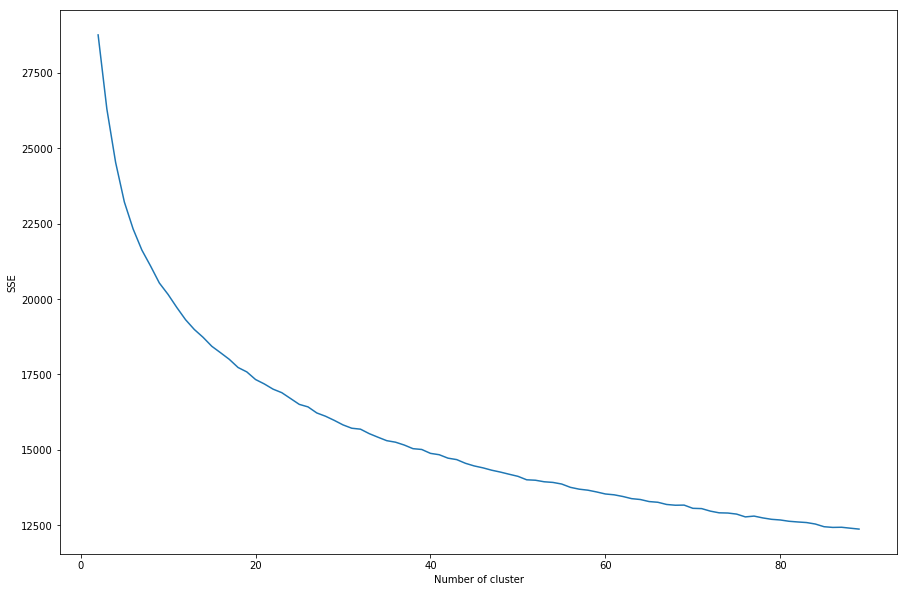

In [80]:
sse = dict()
for K in range(2,90):
    kmeans_model = KMeans(n_clusters=K, max_iter=1000)  
    kmeans_model.fit(X)
    sse[K] = kmeans_model.inertia_

plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE");

We choose $k = 40$.

Fit the KMeans model with $k=40$.

In [21]:
K_OPT = 40
kmeans_model = KMeans(n_clusters=K_OPT, max_iter=1000)
kmeans_model.fit(X)
labels=kmeans_model.labels_.tolist()

Assign words to their label and sort to display the most frequent words.

In [22]:
words_by_label = {label:[] for label in range(K_OPT)}
for i, (word, vocab_obj) in enumerate(model.wv.vocab.items()):
    words_by_label[labels[i]].append((word, vocab_obj.count))
for i in range(K_OPT):
    words_by_label[i].sort(key=lambda tup: tup[1], reverse=True)

In [105]:
print("\n".join([str([elt[0] for elt in words_by_label[i][:10]]) for i in range(K_OPT)]))

['corn', 'key', 'crop', 'soybean', 'planting', 'work', 'support', 'agricultural', 'wheat', 'weather']
['earlier', 'value', 'countries', 'discussion', 'general', 'assessments', 'resulted', 'times', 'paranagua', 'contacts']
['this', 'by', 'that', 'will', 'not', 'more', 'over', 'any', 'other', 'into']
['fob', 'around', 'cfr', 'offers', 'reported', 'fob.', 'cfr.', 'deals', 'roughly', 'cfr,']
['ground', 'real', 'requirement', 'driven', 'knowledge', 'them', 'up,', 'team', 'invest', 'first-hand']
['dap/map', 'it', 'sold', 'shipment', 'cargo', 'july', 'april', 'june', 'believed', 'two']
['average', 'net', 'billion', 'quarter', 'said.', 'potash', 'output', 'nitrogen', 'produced', 'posted']
['and', 'an', 'may', '\n\nthe', 'previously', 'moroccan', 'asian', 'enquiries', 'official', '\n\nat']
['plant', 'chief', 'press', 'mine', 'project', 'joint', 'environmental', 'raw', 'industry', 'plants']
['which', 'september', 'october', 'international', 'three', 'west', 'dap,', 'close', 'trading', 'technical

# Demo

In [4]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

path = get_tmpfile("word2vec.model")

model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [5]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [6]:
model = Word2Vec.load("word2vec.model")
model.train([["hello", "world"]], total_examples=1, epochs=1)

(0, 2)

In [7]:
vector = model.wv['computer']

In [8]:
vector

array([-4.7318428e-03, -8.0928243e-05, -4.5646937e-03,  1.4201301e-03,
        1.3051381e-03, -4.8533157e-03,  3.7457431e-03,  4.8109628e-03,
        9.3463040e-04, -9.5737498e-04, -2.3004590e-03,  2.2184646e-03,
        1.9172309e-03,  2.6884902e-04, -2.9147172e-03, -1.2778580e-03,
       -3.8432358e-03,  2.5077951e-03, -1.8752380e-03, -2.5003094e-03,
        9.6803845e-04,  4.2682523e-03,  1.0176175e-03,  1.2495719e-05,
        1.1685709e-03,  2.5554125e-03,  5.3820910e-04,  3.5671482e-03,
       -2.1910899e-04, -4.0582381e-03, -3.2822858e-04, -3.3796979e-03,
        5.0007575e-03, -4.4999644e-03, -2.4789323e-03, -8.8392233e-04,
       -6.7270783e-05,  8.3375431e-04,  2.5172057e-03, -2.1044735e-03,
       -1.0891407e-03, -4.6986942e-03, -8.6203008e-04,  1.1637164e-03,
        2.9150243e-03, -3.5794592e-03, -1.3648985e-04, -1.1773553e-03,
        2.0458673e-03,  1.1815886e-03, -3.6946656e-03, -2.0553553e-04,
       -1.4833674e-03, -8.6467437e-05, -2.0604925e-03, -1.9085982e-03,
      

In [24]:
a = (1,2)